In [141]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [142]:
import numpy as np
import pandas as pd

In [143]:
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [144]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [145]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [146]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [147]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [148]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [149]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [150]:
# Print Fields in the Table of the Database
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(f'{c["name"]}      \t{c["type"]}')

id      	INTEGER
station      	TEXT
date      	TEXT
prcp      	FLOAT
tobs      	FLOAT


In [151]:
# Print Fields in the Table of the Database
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(f'{c["name"]}      \t{c["type"]}')

id      	INTEGER
station      	TEXT
name      	TEXT
latitude      	FLOAT
longitude      	FLOAT
elevation      	FLOAT


# Exploratory Climate Analysis

In [152]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


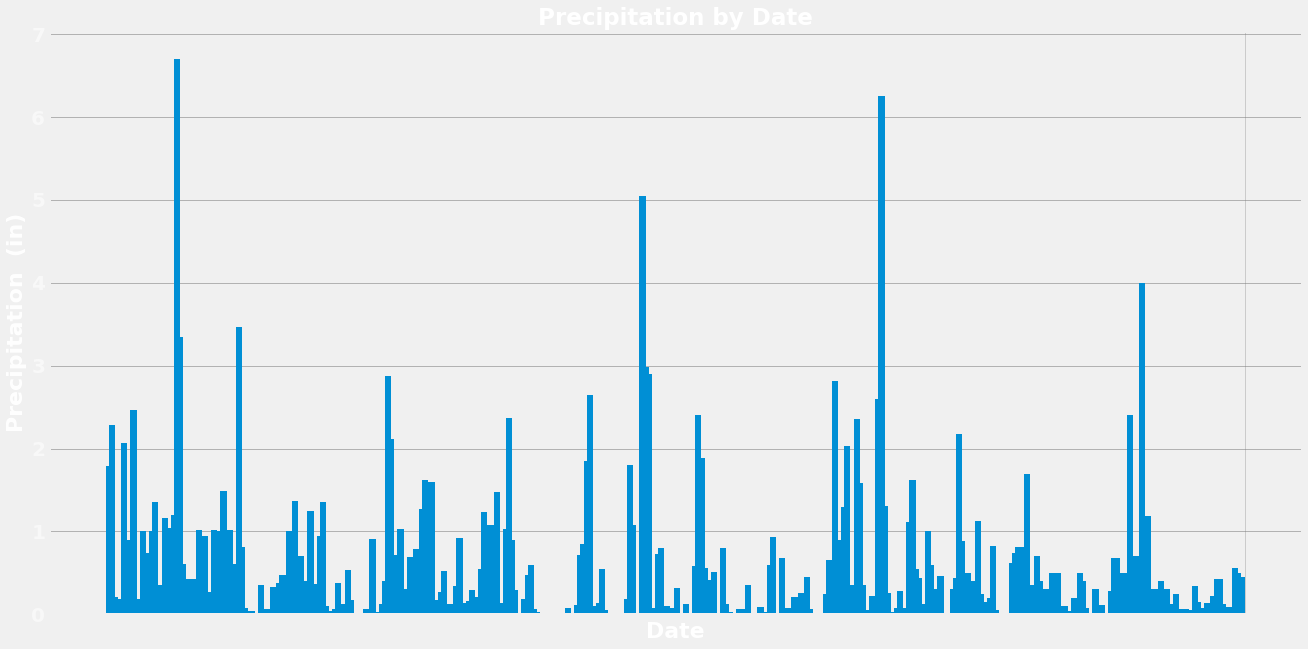

In [153]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


precipitation = session.query(Measurement.date,Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').\
                    order_by(Measurement.date).all()

precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])
precipitation_df = precipitation_df.sort_values(by='Date', ascending=True)
#precipitation_df = precipitation_df.dropna()

# For setting up the index
# precipitation_df.set_index('Date', inplace=True)

# Resize the plot
plt.figure(figsize=(20,10));

# Plot the precipitation
plt.bar(precipitation_df["Date"], precipitation_df["Precipitation"], align='center', width=2 );

# Define the reference font size
ref_font_size = 20

# Add labels and Title
plt.xlabel('Date',fontweight="bold", fontsize=ref_font_size+2);
plt.ylabel('Precipitation  (in)',fontweight="bold", fontsize=ref_font_size+2);
plt.title('Precipitation by Date' ,fontweight="bold", fontsize=ref_font_size+3);

# Add Grids
plt.grid(b=bool, which='major', axis='y', color='grey',  alpha=0.55);

# Add ticks
plt.xticks("", rotation=90, fontweight="bold", alpha=0.55);
plt.yticks(rotation=0, fontweight="bold", alpha=0.55, fontsize=ref_font_size);

# Save Plot
plt.savefig("Fig 1. Barchart - Precipitation by Date" +'.png',bbox_inches='tight');

#Show the Plot
plt.show();

In [154]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# precipitation_df.set_index('Date', inplace=True)
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [155]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [156]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Station.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [157]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station,  func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").\
    group_by(Measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [158]:
temperature = session.query(Measurement.date,  Measurement.tobs).\
                    filter(Measurement.station == "USC00519281").\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').all()

temperature_df = pd.DataFrame(temperature, columns=['Date', 'Temperature'])
temperature_df = temperature_df.sort_values(by='Date', ascending=True)
temperature_df.dtypes
temperature_df["Temperature"]

0      77.0
1      77.0
2      80.0
3      80.0
4      75.0
       ... 
347    77.0
348    77.0
349    76.0
350    76.0
351    79.0
Name: Temperature, Length: 352, dtype: float64

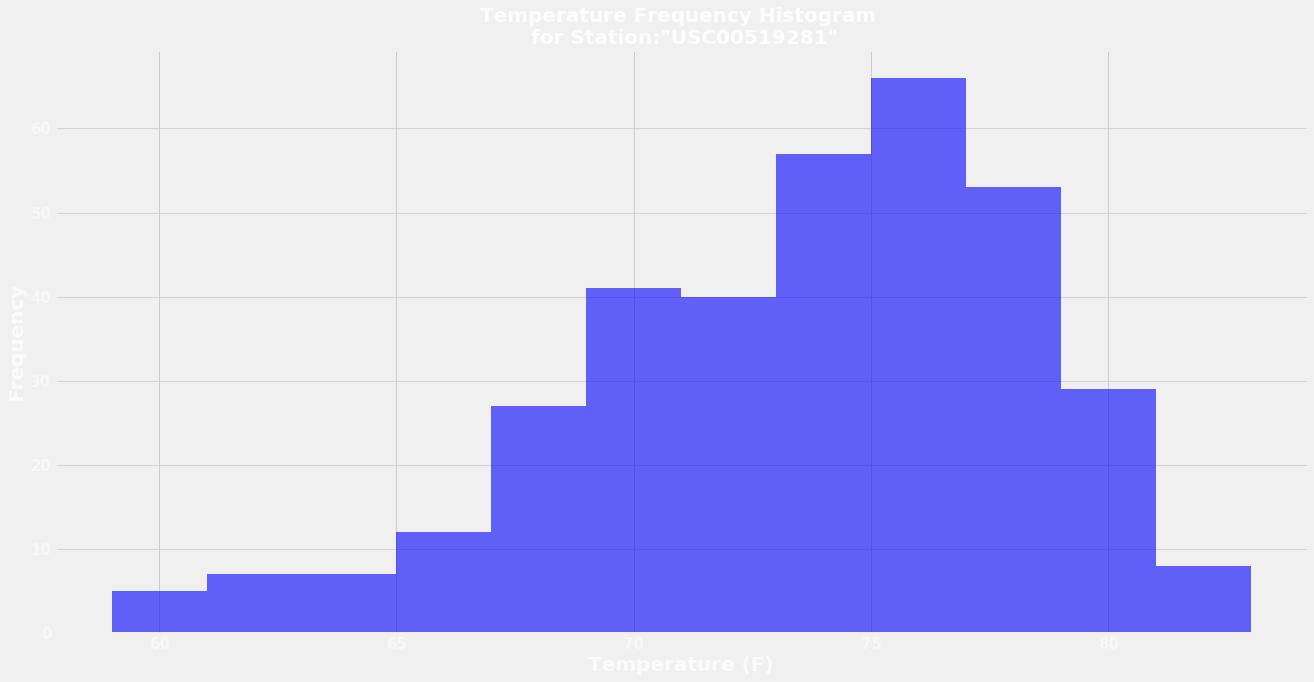

In [159]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.date,  Measurement.tobs).\
                    filter(Measurement.station == "USC00519281").\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').all()

# Temperature dataframe cleanning process
temperature_df = pd.DataFrame(temperature, columns=['Date', 'Temperature'])
temperature_df = temperature_df.sort_values(by='Date', ascending=True)
temperature_df.set_index('Date', inplace=True)

# Resize Plot
plt.figure(figsize=[20,10]);

# Define Histogram paramaters
n, bins, patches = plt.hist(x=temperature_df["Temperature"], bins=12, 
                           color='blue',alpha=0.6);
# Labeling, tickers and grids
plt.grid(axis='y', alpha=0.75);
plt.xlabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.ylabel('Frequency',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Temperature Frequency Histogram \n for Station:"USC00519281"',
          fontweight="bold", alpha=0.9, fontsize=20);

# Save Plot
plt.savefig("Fig 2. Histogram - Temperature Frequency for Station USC00519281" +'.png',bbox_inches='tight');

#Show the Plot
plt.show();

In [160]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [161]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Vacation Dates
initial_vacation_date = "2016-12-24"
final_vacation_date = "2017-01-08"

# Previous Year Dates
initial_prevyear_date = "2015-12-24"
final_prevyear_date = "2016-01-08"

# Max, min and average calculation
min_vacation_temp = calc_temps(initial_prevyear_date, final_prevyear_date)[0][0]
avg_vacation_temp = calc_temps(initial_prevyear_date, final_prevyear_date)[0][1]
max_vacation_temp = calc_temps(initial_prevyear_date, final_prevyear_date)[0][2]

print(min_vacation_temp, avg_vacation_temp, max_vacation_temp)

62.0 71.27956989247312 79.0


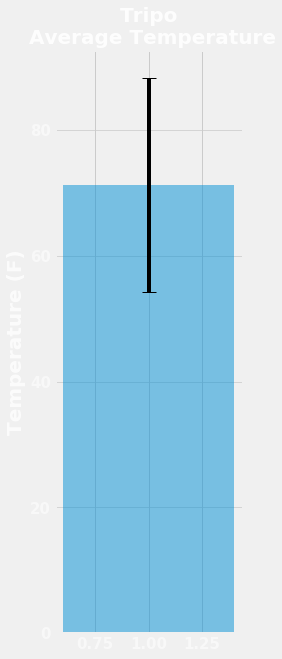

In [162]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error_prev_year = max_vacation_temp-min_vacation_temp

# Resize Plot
plt.figure(figsize=[3,10]);

# Define Bar and Error paramaters
plt.bar(1, avg_vacation_temp, yerr=error_prev_year, align='center', alpha=0.5, ecolor='black', capsize=7)

# Labeling, tickers and grids
plt.grid(axis='y', alpha=0.75);
plt.ylabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Tripo\n Average Temperature',
          fontweight="bold", alpha=0.9, fontsize=20);

# Save Plot
plt.savefig("Fig 3. Barchart - Trip Average Temperature" +'.png',bbox_inches='tight');

#Show the Plot
plt.show();

In [163]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station,  Station.name, Station.latitude, Station.longitude, Station.elevation).\
   filter(Station.station == Measurement.station).\
       filter(Measurement.date >= initial_prevyear_date).filter(Measurement.date <= final_prevyear_date).\
           group_by(Measurement.station).\
               order_by(Measurement.prcp.desc()).all()


[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

## Optional Challenge Assignment

In [164]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")[0]

(62.0, 69.15384615384616, 77.0)

In [165]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

from datetime import timedelta  

# Vacation Dates
initial_vacation_date = dt.date(2016,12,24)
final_vacation_date = dt.date(2017,1,8) 

# Initialize variables for while loop
date_while = initial_vacation_date 
vacation_dates = [date_while]

# Create a list with all the dates within the vacation range
while date_while < final_vacation_date:
    date_while += timedelta(days=1)
    vacation_dates.append(date_while)

# Calculate the normals in the list of vacation dates using the  %m-%d strings
normals = []
dates_normal = []
for date_for in vacation_dates:
    date_no_year = date_for.strftime('%m') + "-" + date_for.strftime('%d')
    normals.append(daily_normals(date_no_year)[0])
    dates_normal.append(date_no_year)

# Print the results
normals

[(62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0),
 (62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0)]

In [166]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index=vacation_dates, columns = ['T Min' , 'T Avg', 'T Max']) 
normals_df.index.name = "Vacation Date"
normals_df

,T Min,T Avg,T Max
Vacation Date,,,
2016-12-24,62.0,70.062500,78.0
2016-12-25,60.0,71.750000,79.0
2016-12-26,63.0,71.446809,77.0
2016-12-27,62.0,71.916667,79.0
2016-12-28,62.0,70.520833,77.0
2016-12-29,57.0,70.291667,78.0
2016-12-30,63.0,69.863636,76.0
2016-12-31,56.0,68.279070,77.0
2017-01-01,62.0,69.153846,77.0


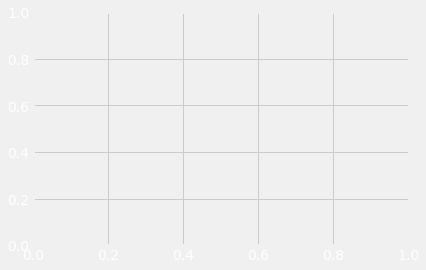

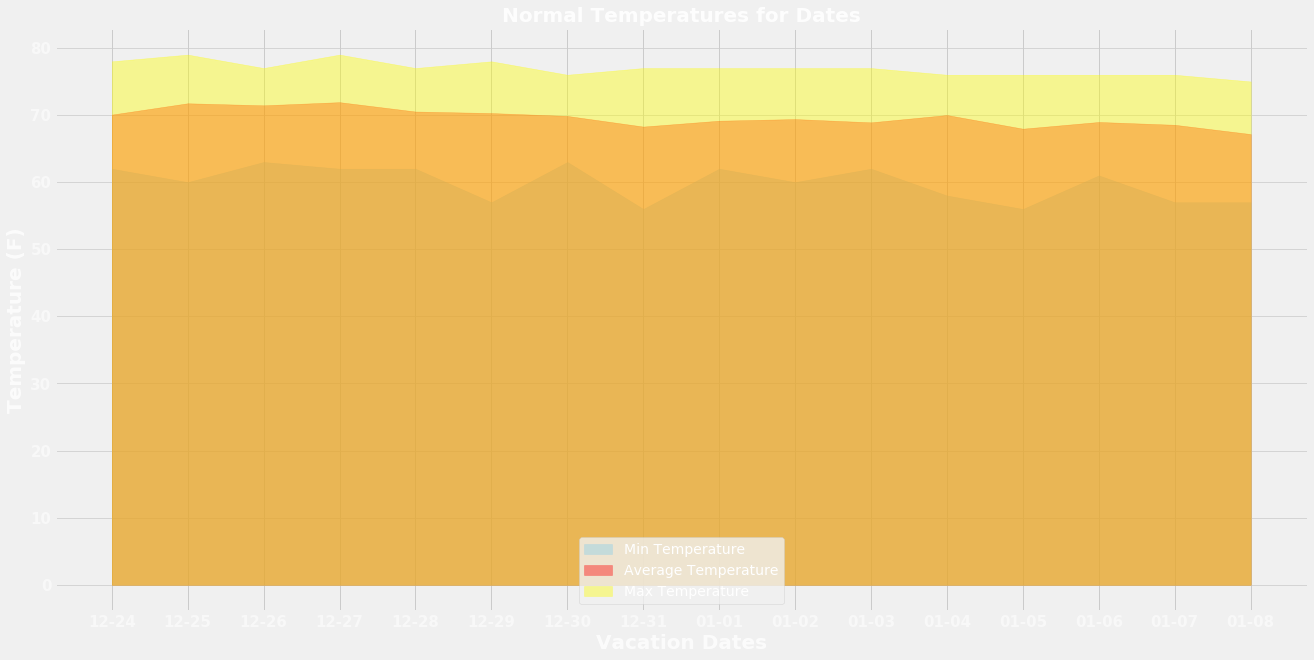

In [167]:
# Plot the daily normals as an area plot with `stacked=False`

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot# Data
x= dates_normal
y= [normals_df["T Min"], normals_df["T Avg"], normals_df["T Max"]]


fig, ax1 = plt.subplots()

# Resize Plot
plt.figure(figsize=[20,10]);

# Plot
#plt.stackplot(x,y, color=['red', 'blue', 'yellow'], alpha = 0.5, baseline='zero')

plt.fill_between( x, normals_df["T Min"], color="skyblue", alpha=0.4)
plt.fill_between( x, normals_df["T Avg"], color="red", alpha=0.4)
plt.fill_between( x, normals_df["T Max"], color="yellow", alpha=0.4)


plt.legend(('Min Temperature', 'Average Temperature', 'Max Temperature'),loc='lower center')


# Labeling, tickers and grids
plt.grid(axis='y', alpha=0.75);
plt.xlabel('Vacation Dates',fontweight="bold", alpha=0.8, fontsize=20);
plt.ylabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Normal Temperatures for Dates',
          fontweight="bold", alpha=0.9, fontsize=20);

# Save Plot
plt.savefig("Fig 4. Area Plot - Normal Temperatures for Vacation Dates" +'.png',bbox_inches='tight');

#Show the Plot
plt.show();
